# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Compute the camera calibration using chessboard images

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

In [1]:
import numpy as np
import cv2
import glob

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
success_imgs = []  # Images where we detected corners successfully
failed_imgs = []   # Images where we failed to detect corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        success_imgs.append(cv2.drawChessboardCorners(img, (9,6), corners, ret))
    else:
        failed_imgs.append(img)

Next code cell demostrates the corners found on Chessboard.

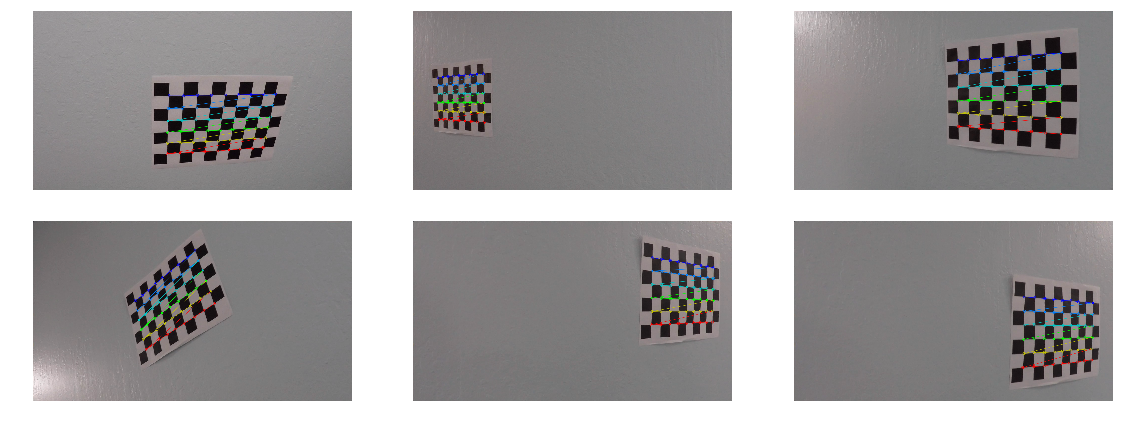

In [2]:
import matplotlib.pyplot as plt
import math

# %matplotlib qt
%matplotlib inline

f = plt.figure(figsize = (16, 6))
num_column = 3
num_row = 2

for i, img in enumerate(success_imgs[0:6]):
    ax = f.add_subplot(num_row, num_column, i + 1)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. 

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

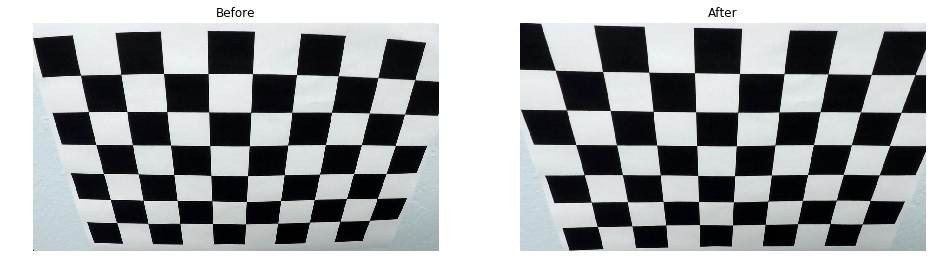

In [4]:
img = cv2.imread('../camera_cal/calibration2.jpg')

dst = cv2.undistort(img, mtx, dist, None, mtx)
f = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Before')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(dst)
plt.title('After')
plt.axis('off')
plt.show()

## 2. Pipeline for single image

The pipeline contains the following steps:

1. Apply a distortion correction to raw images.
2. Apply a perspective transform to rectify binary image ("birds-eye view").
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [5]:
# Some helper methods

def is_binary_img(img):
    h_w_d = img.shape
    return (len(h_w_d) == 2 or (len(h_w_d) == 3 and h_w_d[2]== 1))

def plot_side_by_side(left_img, left_title, right_img, right_title):
    %matplotlib inline
    f, axs = plt.subplots(1, 2, figsize = (16, 8))
    
    if is_binary_img(left_img):
        axs[0].imshow(left_img, cmap='gray')
    else:
        axs[0].imshow(left_img)
    axs[0].set_title(left_title)

    if is_binary_img(right_img):
        axs[1].imshow(right_img, cmap='gray')
    else:
        axs[1].imshow(right_img)
    axs[1].set_title(right_title)
    
# matplotlib qt
%matplotlib inline

import glob
file_names = glob.glob('../test_images/*.jpg')
test_imgs = [cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB) for file_name in file_names]

### 2.1 Provide an example of a distortion-corrected image.

I applied the distortion correction calculated above to an image using the cv2.undistort() function and obtained the following result:

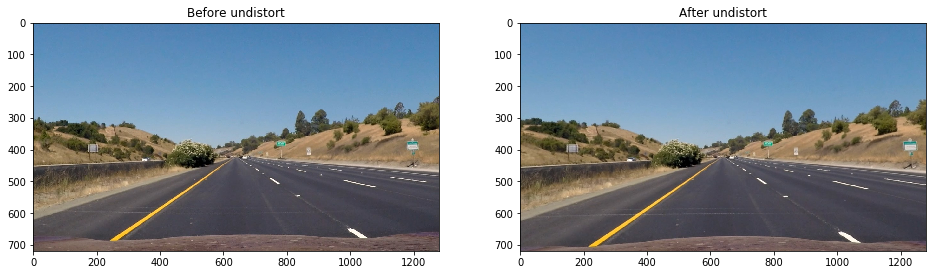

In [6]:
def undistort(img):
    """Un-distort image
    """
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

test_img = test_imgs[0]
undistorted = undistort(test_img)
plot_side_by_side(test_img, 'Before undistort', undistorted, 'After undistort')

### 2.2 Perspective Transform

The `perspective_transform()` function takes as inputs an image (img) and returns transformed image, transform matrix and inverse transform matrix. 

To calculate perspective transform matrix, cv2.getPerspectiveTransform method need 4 source points and 4 destination points. I chose the hardcode the source and destination points in the following manner:


| Source         | Destination|
|----------------|------------|
| (568, 468.5)   | (400, 0)   |
| (715, 468.5)   | (880, 0)   |
| (1041.5, 679.1)| (880, 710) |
| (269.5, 679.1) | (400, 710) |

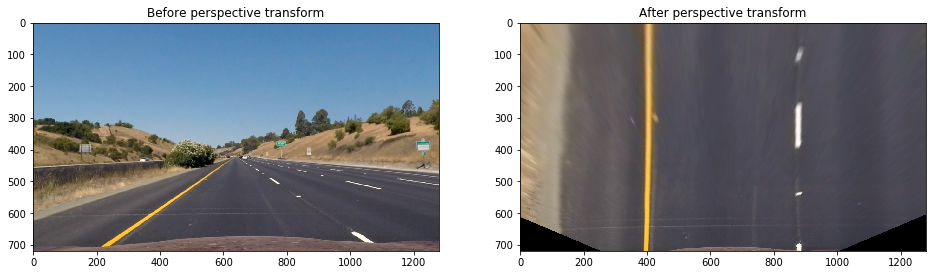

In [7]:
def perspective_transform(img):
    src = np.float32([
        [568, 468.5],
        [715, 468.5],
        [1041.5, 679.1],
        [269.5, 679.1]
    ])
    
    dest = np.float32([
        [400, 0],
        [880, 0],
        [880, 710],
        [400, 710]
    ])
    
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    
    wrapped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)

    return wrapped, M, Minv


test_img = test_imgs[0].copy()
undistorted = (undistort(test_img))
warped, M, Minv = perspective_transform(undistorted)
plot_side_by_side(undistorted, 'Before perspective transform', warped, 'After perspective transform')

### 2.3 Create a thresholded binary image 

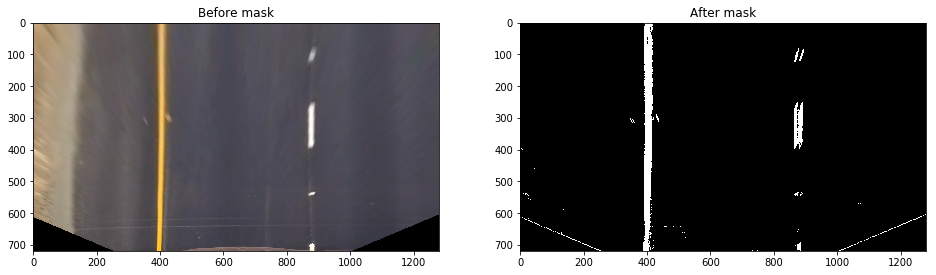

In [8]:
def apply_gradient_mask(img):    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

img = test_imgs[0]
undistorted = (undistort(img))
warped, M, Minv = perspective_transform(undistorted)
binary_warped = apply_gradient_mask(warped)
plot_side_by_side(warped, 'Before mask', binary_warped, 'After mask')

### 2.4 Find lanes

find_lane method in the following code cell finds the left and right lanes. It first finds pixels that are likely from left and right lanes, then it uses two second order polynomials to fit them.

find_lane_pixels method finds pixels from left and right lane. It first takes a histogram along all the columns in the lower half of the image (see get_histogram method below). Second it finds the x-positions of the base of the lanes using the two most prominent peaks in the histogram. Next, it uses a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

In [9]:
def find_lane_pixels(binary_warped):
    assert len(binary_warped.shape) == 2, "img is not binary, img.shape = {}".format(binary_warped.shape)
    
    # Take a histogram along all the columns in the lower half of the image.
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)

    # Find x-positions of the base of the lanes using the two most prominent peaks in the histogram.
    mid = np.int(len(histogram)//2)
    left_win_center = np.argmax(histogram[0:mid])
    right_win_center = np.argmax(histogram[mid:]) + mid
    
    # Use a sliding window to find and follow the lines up to the top of the frame
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)


    margin = 100
    nonzero = binary_warped.nonzero()
    min_nonzero_pixel_count = 200
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = []
    right_lane_inds = []
    # print("nonzero len {}".format(len(nonzero[0])))
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    h = binary_warped.shape[0]
    left_windows = []
    right_windows = []
    for i in range(nwindows):
        # Create two rectangular windows
        win_top = h - (i + 1) * window_height
        win_bottom = win_top + window_height
        left_win_left = left_win_center - margin
        left_win_right = left_win_center + margin
        right_win_left = right_win_center - margin
        right_win_right = right_win_center + margin
        # print("top {}, bottom {}, left win ({}, {}), right win ({} {})".format(win_top, win_bottom, left_win_left, left_win_right, right_win_left, right_win_right))
        
        # cv2.rectangle(out_img, (left_win_left, win_bottom), (left_win_right, win_top), (0, 255, 0), 2)
        # cv2.rectangle(out_img, (right_win_left, win_bottom), (right_win_right, win_top), (0, 255, 0), 2)
        left_windows.append(((left_win_left, win_bottom), (left_win_right, win_top)))
        right_windows.append(((right_win_left, win_bottom), (right_win_right, win_top)))
        
        # Identify the nonzero pixels in x and y within the window
        left_inds = ((nonzeroy >= win_top) & (nonzeroy < win_bottom) & (nonzerox >= left_win_left) & (nonzerox < left_win_right)).nonzero()[0]
        right_inds = ((nonzeroy >= win_top) & (nonzeroy < win_bottom) & (nonzerox >= right_win_left) & (nonzerox < right_win_right)).nonzero()[0]
        # print("left pixel count {}, right pixel count {}".format(len(left_inds), len(right_inds)))
        # Append these indices to the lists
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)
        
        # Move the center of windows
        if len(left_inds) > min_nonzero_pixel_count:
            left_win_center = np.int(np.mean(nonzerox[left_inds]))
        if len(right_inds) > min_nonzero_pixel_count:
            right_win_center = np.int(np.mean(nonzerox[right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, left_windows, right_windows
    
def find_lane(binary_warped):
    """Find left and right lane in a image.
    Args:
        binary_warped: a binary image that has done perspective transform
    """
    leftx, lefty, rightx, righty, left_windows, right_windows = find_lane_pixels(binary_warped)

    if (len(leftx) == 0):
        left_fit = None
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    if (len(rightx) == 0):
        right_fit = None
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def get_fit_lines(warped, left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

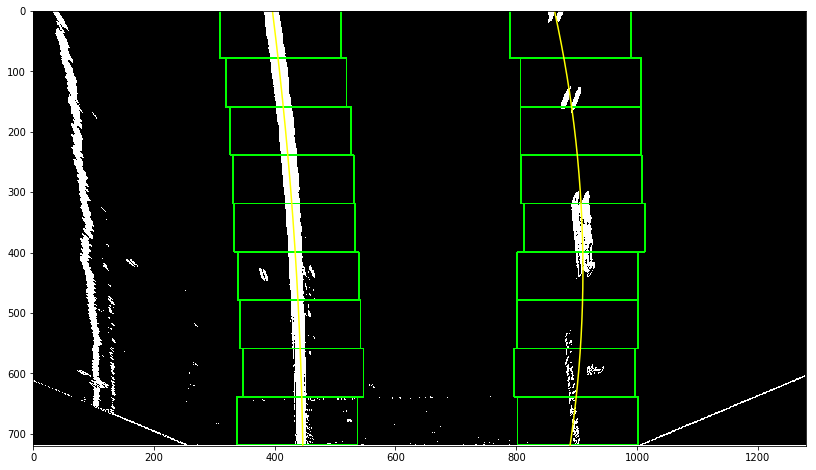

In [10]:
undistorted = (undistort(test_imgs[3]))
warped, M, Minv = perspective_transform(undistorted)
binary_warped = apply_gradient_mask(warped)
leftx, lefty, rightx, righty, left_windows, right_windows = find_lane_pixels(binary_warped)
left_fit, right_fit = find_lane(binary_warped)
left_fitx, right_fitx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
for win in left_windows:
    cv2.rectangle(out_img, win[0], win[1], (0, 255, 0), 2)
for win in right_windows:
    cv2.rectangle(out_img, win[0], win[1], (0, 255, 0), 2)
f = plt.figure(figsize = (16,8))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, binary_warped.shape[1])
plt.ylim(binary_warped.shape[0], 0)
plt.imshow(out_img)
plt.show()

If we know where the lanes are, we can just search in a margin around the previous line position like this:

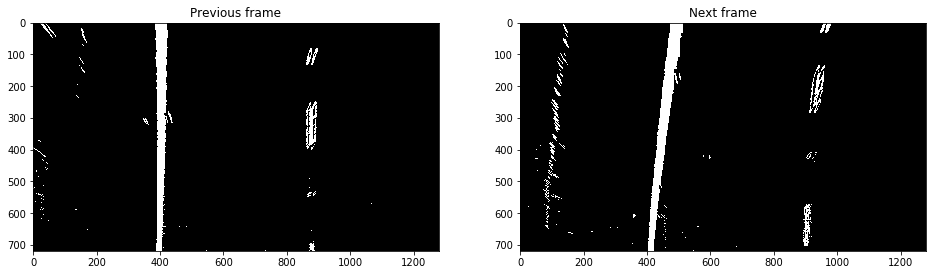

In [11]:
def find_lane_fast(binary_warped, previuos_left_fit, previous_right_fit):
    """Find left and right lanes given previuos left_fit and right_fit
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_center = previuos_left_fit[0]*(nonzeroy**2) + previuos_left_fit[1]*nonzeroy + previuos_left_fit[2]
    right_lane_center = previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2]
    left_lane_inds = ((nonzerox > (left_lane_center - margin)) & (nonzerox < (left_lane_center + margin))) 
    right_lane_inds = ((nonzerox > (right_lane_center - margin)) & (nonzerox < (right_lane_center + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

binary_warped, M, Minv = perspective_transform(apply_gradient_mask(undistort(test_imgs[0])))
binary_warped_next, M, Minv = perspective_transform(apply_gradient_mask(undistort(test_imgs[4])))
left_fit, right_fit = find_lane(binary_warped)
left_fit_next, right_fit_next = find_lane_fast(binary_warped_next, left_fit, right_fit)

left_fitx, right_fitx, ploty = get_fit_lines(binary_warped_next, left_fit_next, right_fit_next)
f = plt.figure(figsize = (16,8))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, binary_warped_next.shape[1])
plt.ylim(binary_warped_next.shape[0], 0)
plt.imshow(binary_warped_next)
plot_side_by_side(binary_warped, 'Previous frame', binary_warped_next, 'Next frame')

### 2.5 Calculate Radius of Curvature

With lane detected, we can calculate the radius of curvature and distance from lane center.

The first step is convert from pixel space to real world space. US regulations require a minimum lane width of 3.7 meters. And dashed lane lines are 3 meters long. From the following image, we can see that lane width is 480 pixel and dashed lane line length is about 130 pixel. For on X direction, about 10/130 meter per pixel, and on Y direction, about 3.7/440 meter per pixel.

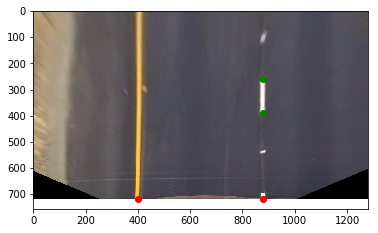

In [12]:
test_img = test_imgs[0]
undistorted = (undistort(test_img))
warped, M, Minv = perspective_transform(undistorted)
f = plt.figure()
plt.imshow(warped)
plt.plot([400, 880], [720, 720], 'ro')
plt.plot([880, 880], [260, 390], 'go')
plt.show()

After mapping x and y points to real world space, I fit the points using a second order polynomial $$f(y)=Ay^2 + By + C$$

Then the radius of curvature is: $$r = \frac{(1+(2Ay + B)^2)^{3/2}}{|2A|}$$

For our application, we are interested in the radius at the bottom of the image.

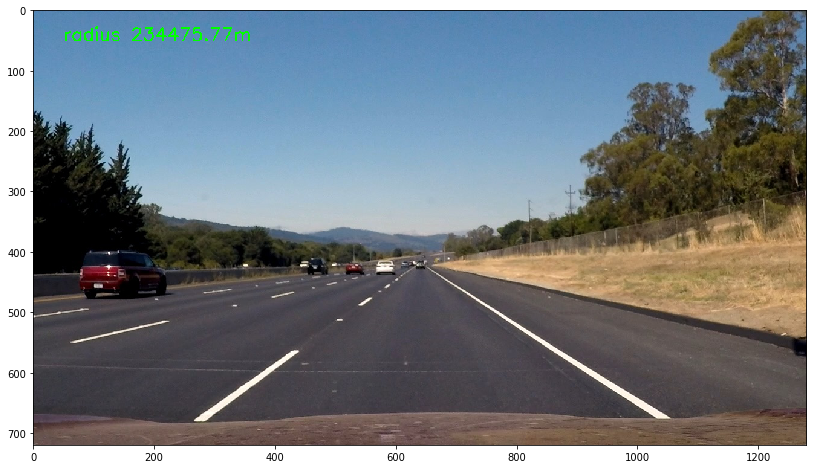

In [13]:
def calculate_curvature(fitx, ploty):
    """ Calculate radius
    Args:
        fitx: x values of fitted line in pixel space
        ploty: y values of fitted line in pixel space
        
    Returns: raduis in meters at the bottom of image
    """
    x_m_per_pix = 3.7/480
    y_m_per_pix = 10/130.0
    
    fitx_m = fitx * x_m_per_pix
    ploty_m = ploty * y_m_per_pix

    y_m = np.max(ploty_m)
    fit = np.polyfit(ploty_m, fitx_m, 2)
    curverad = ((1 + (2 * fit[0] * y_m + fit[1])**2)**1.5) / np.absolute(2 * fit[0])
    return curverad

def calculate_average_curvature(binary_warped, left_fit, right_fit):
    leftx, rightx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
    left_radius = calculate_curvature(leftx, ploty)
    right_radius = calculate_curvature(rightx, ploty)
    return (left_radius + right_radius) / 2

img = test_imgs[1]
undistorted = undistort(img)
binary_warped, M, Minv = perspective_transform(apply_gradient_mask(undistorted))
left_fit, right_fit = find_lane(binary_warped)
leftx, rightx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
left_radius = calculate_curvature(leftx, ploty)
right_radius = calculate_curvature(rightx, ploty)

newImage = img.copy()
f = plt.figure(figsize = (16,8))
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(newImage,"radius {:.2f}m".format(calculate_average_curvature(binary_warped, left_fit, right_fit)),(50,50), font, 1,(0,255,0),2)
plt.imshow(newImage)
plt.show()

### 2.6 Distance from Center

Pass sanity check True


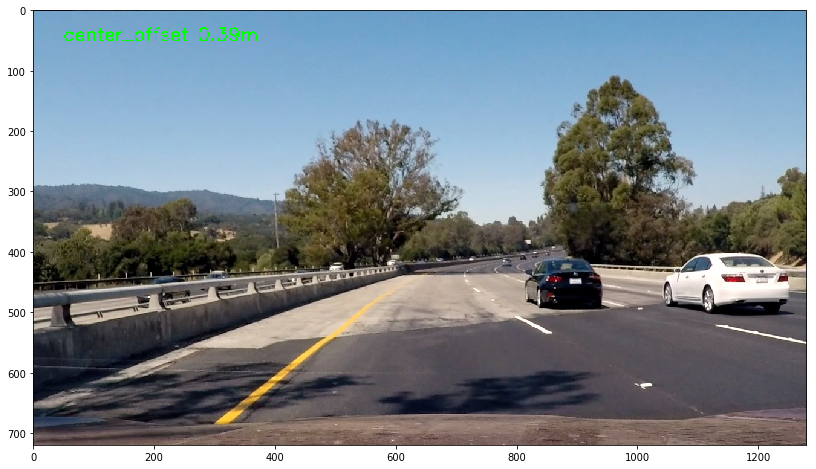

In [14]:
def get_lane_values(left_fitx, right_fitx, ploty):
    x_m_per_pix = 3.7/480
    
    mean_distance = np.mean(right_fitx - left_fitx) * x_m_per_pix
    
    lane_center = (left_fitx[-1] + right_fitx[-1]) // 2
    car_center = 1280/2
    center_offset = (lane_center - car_center) * x_m_per_pix
    
    return mean_distance, center_offset

def check_sanity(binary_warped, left_fit, right_fit):
    leftx, rightx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)    
    mean_distance, center_offset = get_lane_values(leftx, rightx, ploty)
    
    if mean_distance < 2.5 or mean_distance > 5:
        return False
    if center_offset > 2:
        return False
    
    left_radius = calculate_curvature(left_fitx, ploty)
    right_radius = calculate_curvature(right_fitx, ploty)
    radius = (left_radius + right_radius)/2
    if radius < 30:
        return False
    
    if radius < 10000 and (left_fit[0] * right_fit[0]) < 0:
        return False
    return True

img = test_imgs[5]

undistorted = undistort(img)
binary_warped, M, Minv = perspective_transform(apply_gradient_mask(undistorted))
left_fit, right_fit = find_lane(binary_warped)
leftx, rightx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
mean_distance, center_offset = get_lane_values(leftx, rightx, ploty)
print("Pass sanity check {}".format(check_sanity(binary_warped, left_fit, right_fit)))

newImage = img.copy()
f = plt.figure(figsize = (16,8))
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(newImage,"center_offset {:.2f}m".format(center_offset),(50,50), font, 1,(0,255,0),2)
plt.imshow(newImage)
plt.show()

### 2.6 Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

The `draw_lane` method in the below code cell draws detected lane, it also displays lane curvature and vehicle position. First it draws a polygons using the fitted left and right lanes on the warped image, then performs a inverse perspective transform, then overlays the lane on top of the unwarped image.

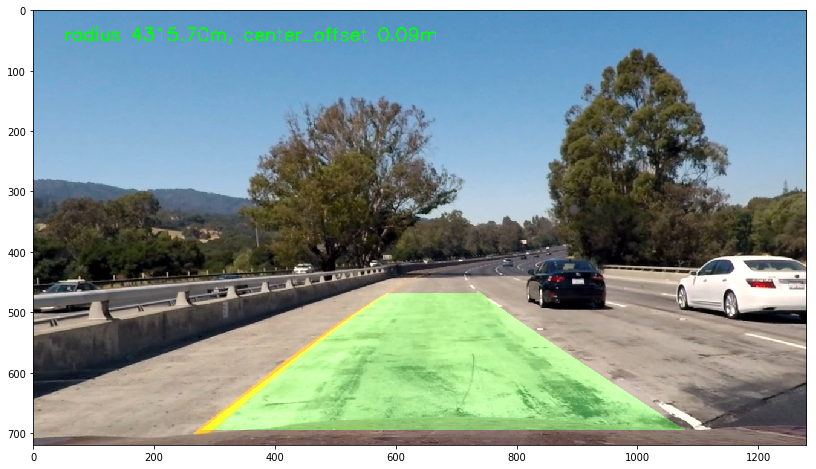

In [15]:
def draw_lane(undist, binary_warped, left_fit, right_fit, Minv):
    """
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx, right_fitx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def draw_text(img, radius, center_offset):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,"radius {:.2f}m, center_offset {:.2f}m".format(radius, center_offset),(50,50), font, 1,(0,255,0),2)
    return img

undistorted = undistort(test_imgs[2].copy())
binary_warped, M, Minv = perspective_transform(apply_gradient_mask(undistorted))
left_fit, right_fit = find_lane(binary_warped)
result = draw_lane(undistorted, binary_warped, left_fit, right_fit, Minv)
leftx, rightx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
mean_distance, center_offset = get_lane_values(leftx, rightx, ploty)
radius = calculate_average_curvature(binary_warped, left_fit, right_fit)
result = draw_text(result, radius, center_offset)
f = plt.figure(figsize = (16,8))
plt.imshow(result)
plt.show()

## 3 Video Pipeline

Using the methods created in previous section, we can build a pipeline to process video. The main difference is that the video pipeline would try to find lanes using lane positions from previous frame.

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
Left=Line()
Right=Line()
no_of_bad_lines=13

def process_image(img):
    """Draw lane area & calculate radius
    
    Returns: an image with lane area drawn
    """
    undistorted = undistort(img)
    masked = apply_gradient_mask(undistorted)
    binary_warped, M, Minv = perspective_transform(masked)
    left_fit = None
    right_fit = None
    if Left.best_fit == None or Right.best_fit == None:
        left_fit, right_fit = find_lane(binary_warped)
    else:
        left_fit, right_fit = find_lane_fast(binary_warped, Left.best_fit, Right.best_fit)
        if not check_sanity(binary_warped, left_fit, right_fit):
            left_fit, right_fit = find_lane(binary_warped)
    Left.best_fit = left_fit
    Right.best_fit = right_fit
    leftx, rightx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
    mean_distance, center_offset = get_lane_values(leftx, rightx, ploty)
    radius = calculate_average_curvature(binary_warped, left_fit, right_fit)
    # print('{}, {}, {}'.format(radius, left_fit, right_fit))
    result = draw_lane(img, binary_warped, Left.best_fit, Right.best_fit, Minv)
    result = draw_text(result, radius, center_offset)
    return result

from moviepy.editor import VideoFileClip
video_output = 'result.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [03:50<00:00,  5.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

